In [1]:
#Selecting a GPU on my system...
!nvidia-smi

Fri Feb 21 09:24:20 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti      Off| 00000000:1A:00.0 Off |                  N/A |
| 16%   26C    P8                1W / 250W|     18MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'


#### Context
As a starting point, we want to try to undersand the phase space evolution of a non-relativistic, pressure-less fluid that interacts only gravitationally (i.e. cold dark matter). The evolution of the phase space distribution function, $f(x,p,t)$, of this fluid in a fixed background can be described by the Vlasov equations,

$\frac{\partial f}{\partial t} + \frac{1}{m} \mathbf{p} \cdot \nabla f 
                             - m \nabla \phi \cdot \frac{\partial f}{\partial \mathbf{p}} = 0 \, \, ,$
                             
where $\mathbf{p}=m\mathbf{u}_i$ is the momenta, $m$ is the particle mass, and $\phi$ is the gravitational potential. In practice solving this as a continuum equation is impractical in the astrophysical context and instead the common approach is to monte carlo sample it at some initial time. We then evolve the discrete particles as an N-body system. Hamilton's equations for this system become

$    \frac{d \mathbf{x}_i}{d t}       = \mathbf{u}_i \\
    \frac{d (\mathbf{u}_i)}{d t} = \mathbf{g}_i$
    
where $\mathbf{x}$ ($\mathbf{u}$) is the location (peculiar velocity) for $i$th particle and $\mathbf{g}_i$ is the gravitational field evaluated at $\mathbf{x}_i$ at time $t$.

We are mostly interested in the inverse problem: Given some (noisy) measurement of $f(x,p,t_f)$ what is the distribution of possible $f(x,p,t_o)$?

### Some preliminary thoughts... (disorganized)

1) Since we are interested in the phase space distribution $f(x,p,t)$ we need to map the particle locations/velocities to our choosen coordinates to get an estimate of f. This can be done differentiably via cic_readout-style commands.

2) In full generality, we might want to essentially want to make a differentiable pipeline to go from any $f(x,p,t_0)$ to inital particle position/velocities $\mathbf{x}_i$, $\mathbf{u}_i$, to final $f(x,p,t_f)$, possibly followed by some "observable" function which projects the final distribution function to some other space. (i.e. maybe we only know final positions but not velocities, or only velocities in certain directions or at certain points)

3) In practice, we likely have/want/need a prior on the initial distribution or otherwise constrain it to have some parametrized form. In this case we could maybe have some principled way to go from a known input distribution of points to the initial points. This could depend on a stochastic field we might want to constrain (for example, the intitial phases of a gaussian random field used to model the initial state of the univers) or possibly a random number that will be treated as an input with a fixed distribution (a.la. the reparametrization trick). 

4) The fully general case where we map from $f(x,p,t_0)$ to inital particle position/velocities seems a bit hard to do differentiably in a stable way. There is maybe some trick from diffusion models to be used here. I have implemented an iterative, multidimensional, inverse sampling transform method which seems to vaguely work. (will add notebook eventually) However the derivatives are a bit noisy... Probably to start it makes sense to test things on parametrized input distributions!

5) There are a couple of ways to try to back-propogate through the equations of motion, one is the "direct" approach where the equations of motions are implemented naively in JAX and see what JAX jacfwd and/or jacrev spit out. The alternative is to use the adjoint method which opens up the idea to basically inverse solve the equations and calculate the derivates while doing so. This allows one to avoid saving intermediate states and possibly reduce computations.

6) In the context of going beyond brute-force force calculations, this opens up the question of whether one could build the tree structure on the forward pass and use the same tree structure on the backward pass (very memory intensive?) or possibly rebuild the tree while on the backward pass...

7) Some helpful particle -> field functions are found in the jaxpm (direct approach) and/or pmwd (adjoint approach).

### Helpful References/Resources

#### Github repos

* PMWD: https://github.com/eelregit/pmwd
* JAXPM: https://github.com/DifferentiableUniverseInitiative/JaxPM
* CUDA Barnes Hutt Algorith: https://github.com/Patistar/Nbody-Barnes-Hut-CUDA

#### Some useful blog post

https://patterns.eecs.berkeley.edu/?page_id=193


#### Some other papers
DiffHOD: https://academic.oup.com/mnras/article/529/3/2473/7598219


In [312]:
import jax.numpy as jnp
import jax
from jax import vmap

#two different force calculators, first one does all forces at once, second one can do it in batches for memory reasons (but seems much slower in general)

def efficient_pairwise_forces(pos, softening=1e-5):
        G = jnp.array([vmap(vmap(jnp.subtract, (None, 0)), (0, None))(pos[:,i], pos[:,i]) for i in range(0,3)]) #np.subtract.outer?
        
        #G_wrap = jnp.where(G > 0.5 * dimensions, G - dimensions, G) #wrap around axis for periodic BC, 
        
        r2 = jnp.clip((G**2).sum(axis=0),softening,jnp.inf) #not really "normal" softening, fix maybe
        r3 = r2**(3/2)
        f = G/(r3+1.0E10*jnp.eye(r2.shape[0])) #second term is to ignore self-force
        forces2 = -f.sum(axis=2).T

        return forces2
@jax.jit
def pairwise_forces(positions, softening=1e-3):
    """
    Compute pairwise forces using JAX scan for efficient batched computation.
    
    Args:
        positions: (N, 3) particle positions
        masses: (N,) particle masses
        softening: Numerical stability parameter
    
    Returns:
        Forces: (N, 3) total forces on each particle
    """
    def compute_particle_forces(carry, particle_index):
        # Extract current particle position and mass
        current_pos = positions[particle_index]
        
        # Compute differences from all other particles
        diff = current_pos[jnp.newaxis, :] - positions
        distances = jnp.sqrt(jnp.sum(diff**2, axis=-1) + softening**2)
        G_wrap = distances #jnp.where(distances > 0.5 * dimensions, distances - dimensions, distances)

        # Prevent self-interaction
        force_mask = (distances > softening)
        
        # Gravitational force computation
        force_magnitudes = 1 / (distances**2)
        
        # Force vectors
        unit_vectors = diff / distances[:, jnp.newaxis]
        particle_forces = jnp.sum(force_magnitudes[:, jnp.newaxis] * unit_vectors, axis=0)
        
        return carry, -particle_forces
    
    # Use JAX scan to compute forces for each particle
    _, all_forces = jax.lax.scan(compute_particle_forces, None, jnp.arange(positions.shape[0]))
    
    return all_forces


def make_ode_pp(softening=1e-3,
               grav= 1.0):
    @jax.jit
    def nbody_ode(state,t):
        """
        state is a tuple (position, velocities)
        """
        pos, vel  = state

        forces = efficient_pairwise_forces(pos,softening=softening)


        # Computes the update of position (drift)
        dpos = vel

        # Computes the update of velocity (kick)
        dvel = grav*forces
        
        return dpos, dvel

    return nbody_ode

In [313]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [339]:
n_part = 100
#dimensions = 10
init_pos = np.random.randn(n_part,3)*100
init_vel = np.random.randn(n_part,3)*1

In [364]:
from jax.experimental.ode import odeint #could use diffrax here too
#from scipy.integrate import odeint
snapshots=jnp.linspace(0,100,1000)

res = odeint(make_ode_pp(grav=100), [init_pos, init_vel], snapshots,rtol=1e-5, atol=1e-5)


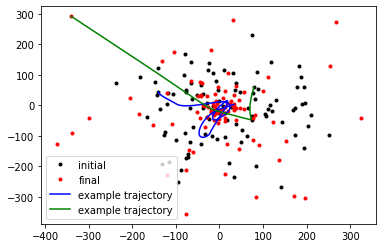

In [381]:
plt.plot(res[0][0,:,0],res[0][0,:,2],"k.",label = "initial")
plt.plot(res[0][-1,:,0],res[0][-1,:,2],"r.",label = "final")
pid = 2
plt.plot(res[0][:,pid,0],res[0][:,pid,2],"b",label = "example trajectory")

pid = 76
plt.plot(res[0][:,pid,0],res[0][:,pid,2],"green",label = "example trajectory")


plt.legend()

In [ ]:
#many particles enter chaotic motion and end up in the center, other ones get thrown out of the halo

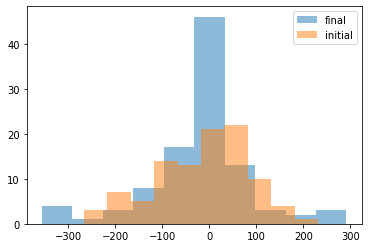

In [372]:
plt.hist(res[0][-1,:,2],alpha=0.5,label = "final")
plt.hist(res[0][0,:,2],alpha=0.5,label = "initial")
plt.legend()